In [1]:
import sys

sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain")
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain\\source")

In [2]:
import torch
from source.visualization.evaluation_visualization import plot_precision_vs_threshold
from source.miscellaneous.evaluation import evaluate_test_image_pair, load_deformation

In [3]:
deformation = load_deformation()

In [4]:
loftr_indoor_matches_image_1 = torch.load("../../models/baseline/loftr_indoor_matches_superbrain_bruteforce_image_1.pt")
loftr_indoor_matches_image_2 = torch.load("../../models/baseline/loftr_indoor_matches_superbrain_bruteforce_image_2.pt")
loftr_indoor_matches_confidence = torch.load("../../models/baseline/loftr_indoor_matches_superbrain_bruteforce_confidence.pt")

In [5]:
confidence_threshold_loftr = 0.8
loftr_outdoor_matches_mask = loftr_indoor_matches_confidence > confidence_threshold_loftr
loftr_indoor_matches_image_1 = loftr_indoor_matches_image_1[loftr_outdoor_matches_mask]
loftr_indoor_matches_image_2 = loftr_indoor_matches_image_2[loftr_outdoor_matches_mask]

In [6]:
(number_of_matches_indoor,
average_distance_indoor,
match_precision_indoor,
auc_indoor,
matches_per_patch_indoor, 
entropy_indoor) = evaluate_test_image_pair(loftr_indoor_matches_image_1, loftr_indoor_matches_image_2, deformation)

c:\Users\robin\Documents\HyperBrain\source\miscellaneous\evaluation.py:93: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/BucketizationUtils.h:34.)
  x_indices = torch.searchsorted(x_borders, x_coords) - 1


In [7]:
auc_indoor, number_of_matches_indoor, entropy_indoor

(7.250300292968751, 2048, 8.572049140930176)

In [25]:
hyperbrain_matches_image_1 = torch.load("../../models/fine_matching/supervised_official_focal_linear_attention/matches_image_1_conf_09.pt")
hyperbrain_matches_image_2 = torch.load("../../models/fine_matching/supervised_official_focal_linear_attention/matches_image_2_conf_09.pt")

In [26]:
(number_of_matches_hyperbrain,
 average_distance_hyperbrain,
 match_precision_hyperbrain,
 auc_hyperbrain,
 matches_per_patch_hyperbrain,
 entropy_hyperbrain) = evaluate_test_image_pair(hyperbrain_matches_image_1, hyperbrain_matches_image_2, deformation)

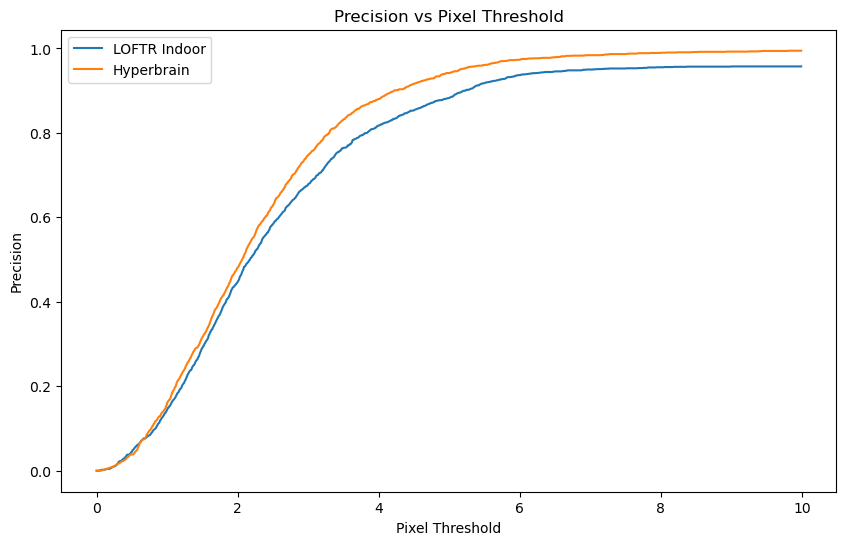

In [27]:
plot_precision_vs_threshold(match_precision_indoor, match_precision_hyperbrain, labels=["LOFTR Indoor", "Hyperbrain"])

<BarContainer object of 2 artists>

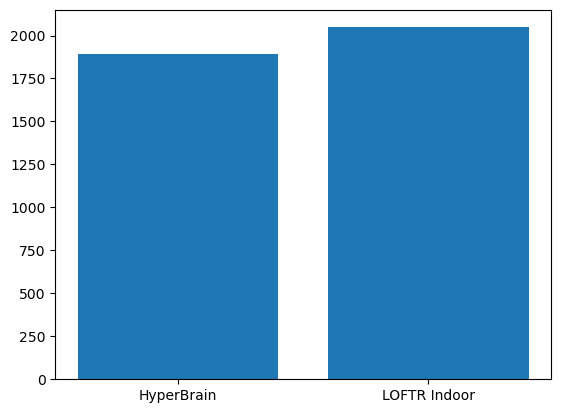

In [28]:
import matplotlib.pyplot as plt
plt.bar(["HyperBrain", "LOFTR Indoor"], [number_of_matches_hyperbrain, number_of_matches_indoor])

In [17]:
# plt.bar(["SuperBrain", "LOFTR Indoor"], [entropy_hyperbrain, entropy_indoor])

In [18]:
from source.miscellaneous.evaluation import compute_euclidean_distances

In [29]:
hyperbrain_matches = torch.column_stack((hyperbrain_matches_image_1, hyperbrain_matches_image_2))

In [30]:
distances = compute_euclidean_distances(predicted_matches=hyperbrain_matches.float(), coordinate_mapping=deformation)
mask = distances < 10

In [31]:
matches_loftr_indoor = torch.column_stack((loftr_indoor_matches_image_1, loftr_indoor_matches_image_2))
distances_loftr_indoor = compute_euclidean_distances(predicted_matches=matches_loftr_indoor.float(), coordinate_mapping=deformation)
mask_lotr_indoor = distances_loftr_indoor < 10

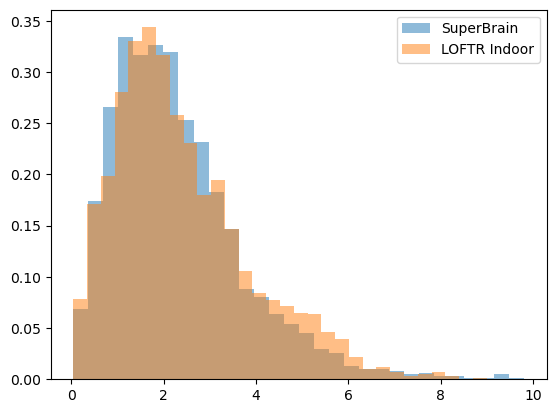

In [38]:
plt.hist(distances[mask], bins=30, density=True, alpha=0.5, label="SuperBrain")
plt.hist(distances_loftr_indoor[mask_lotr_indoor], bins=30, density=True, alpha=0.5, label="LOFTR Indoor")
plt.legend()
plt.show()